In [1]:
import networkx as nx
import pandas as pd
from tqdm import tqdm
from pymongo import MongoClient
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from pathlib import Path

In [2]:

def get_mongo_collection(mongo_db, database_name, collection_name):
    # mongo_db = MongoClient("mongodb://localhost:27017")
    return mongo_db[database_name][collection_name]

mongo_db = MongoClient("mongodb://localhost:27017")

community_collections_path = Path("./data/community_collections")
community_collections_path.mkdir(parents=True, exist_ok=True)

    

In [3]:
def get_graph_for_timestep(self, timestep: int):
    graph = nx.DiGraph()
    # 5k instead of 50k because we only care about the blobs
    graph.add_nodes_from(range(5_000))

    blob_edges: dict[tuple[int, int], int] = {}

    cursor = get_mongo_collection(mongo_db, "calcium", "nodes_level_0")
    results = cursor.find(
        {"step": timestep}, {"_id": 0, "weight": 1, "from_id": 1, "to_id": 1}
    )

    df = pd.DataFrame(list(results))

    for _, row in tqdm(df.iterrows(), total=len(df)):
        if blob_edges.get((row.from_id // 10, row.to_id // 10)):
            blob_edges[(row.from_id // 10, row.to_id // 10)] += row.weight
        else:
            blob_edges[(row.from_id // 10, row.to_id // 10)] = row.weight

    for (from_id, to_id), weight in blob_edges.items():
        graph.add_edge(from_id, to_id, weight=weight)

    return graph


In [4]:

    # def get_edges_for_timestep(collection_name, timestep: int):
    #     cursor = self.get_collection(collection_name)

    #     results = cursor.find(
    #         {"step": timestep}, {"_id": 0, "weight": 1, "from_id": 1, "to_id": 1}
    #     )

    #     df = pd.DataFrame(list(results))



In [41]:
neuron_positions_path = "../data/neuron_positions.csv"
df = pd.read_csv(neuron_positions_path)
df = df.set_index("id")
df["level1"] = df.index // 10


In [42]:
# take the mean of neurons in groups of 10: (getting exactly the blobs) (get nodes of level 1)
nodes_1 = df.groupby(df.index//10).mean().drop(columns=["area_id", "level1"])

# get level 2 communities
blobbed_kmeans = KMeans(n_clusters=625, n_init="auto").fit(nodes_1[["x", "y", "z"]])
centroids = blobbed_kmeans.cluster_centers_
labels = blobbed_kmeans.labels_
nodes_1["level2"] = labels
# nodes_1


# get nodes of level 2 by contracting nodes of same community in level 1:
nodes_2 = nodes_1.groupby("level2").mean()
nodes_2.index = nodes_2.index.rename("id")

# get level 3 communities
level3_kmeans = KMeans(n_clusters=80, n_init="auto").fit(nodes_2[["x", "y", "z"]])
centroids = level3_kmeans.cluster_centers_
level3_labels = level3_kmeans.labels_
nodes_2["level3"] = level3_labels
# nodes_2


# get nodes of level 3 by contracting nodes of same community in level 2:
nodes_3 = nodes_2.groupby("level3").mean()
nodes_3.index = nodes_3.index.rename("id")

# get level 4 communities
level4_kmeans = KMeans(n_clusters=8, n_init="auto").fit(nodes_3[["x", "y", "z"]])
centroids = level4_kmeans.cluster_centers_
level4_labels = level4_kmeans.labels_
nodes_3["level4"] = level4_labels

nodes_4 = nodes_3.groupby("level4").mean()
nodes_4.index = nodes_4.index.rename("id")

# waterfall back all the community id's:
nodes_2 = nodes_2.join(nodes_3["level4"], on="level3")
nodes_1 = nodes_1.join(nodes_2[["level3", "level4"]], on="level2")
df = df.join(nodes_1[["level2", "level3", "level4"]], on="level1")

In [43]:
print("df:\n", df.head(n=10))
print("nodes_1:\n", nodes_1.head(n=10))
print("nodes_2:\n", nodes_2.head(n=10))
print("nodes_3:\n", nodes_3.head(n=10))

df:
             x          y          z  area_id  level1  level2  level3  level4
id                                                                          
0   88.017654  143.88911  83.259131       43       0     289      52       2
1   88.071787  143.79220  83.237149       43       0     289      52       2
2   88.093434  143.95190  83.168331       43       0     289      52       2
3   88.063898  143.81981  83.317563       43       0     289      52       2
4   88.066131  143.97354  83.238470       43       0     289      52       2
5   88.099804  143.94070  83.302861       43       0     289      52       2
6   88.074268  143.94095  83.318852       43       0     289      52       2
7   87.973951  143.88182  83.321619       43       0     289      52       2
8   88.072210  143.88340  83.284350       43       0     289      52       2
9   88.028159  143.86602  83.277468       43       0     289      52       2
nodes_1:
             x           y          z  level2  level3  level4


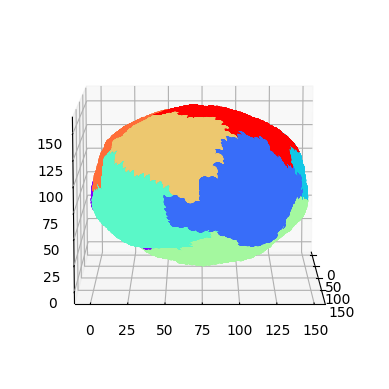

In [44]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=10., azim=0.0)
ax.scatter(df["x"], df["y"], df["z"], c=df["level4"], cmap="rainbow", s=50, alpha=1)
# ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c="red", s=50)
plt.show()

In [45]:
df = df.rename({f"level{i}": f"community_level{i}" for i in range(1, 5)}, axis=1)
nodes_4 = nodes_4.rename({f"level{i}": f"community_level{i}" for i in range(1, 5)}, axis=1)
nodes_3 = nodes_3.rename({f"level{i}": f"community_level{i}" for i in range(1, 5)}, axis=1)
nodes_2 = nodes_2.rename({f"level{i}": f"community_level{i}" for i in range(1, 5)}, axis=1)
nodes_1 = nodes_1.rename({f"level{i}": f"community_level{i}" for i in range(1, 5)}, axis=1)
nodes_1 = nodes_1.rename({"community_level2": "community_id"}, axis=1)
nodes_2 = nodes_2.rename({"community_level3": "community_id"}, axis=1)
nodes_3 = nodes_3.rename({"community_level4": "community_id"}, axis=1)


In [46]:
# df.to_csv(community_collections_path / f"calcium_level_0_nodes.csv")
# nodes_1.to_csv(community_collections_path / f"calcium_level_1_nodes.csv")
# nodes_2.to_csv(community_collections_path / f"calcium_level_2_nodes.csv")
# nodes_3.to_csv(community_collections_path / f"calcium_level_3_nodes.csv")
# nodes_4.to_csv(community_collections_path / f"calcium_level_4_nodes.csv")
nodes_1


,x,y,z,community_id,community_level3,community_level4
id,,,,,,
0,88.056130,143.893945,83.272579,289,52,2
1,88.262038,143.954972,81.270251,289,52,2
2,90.028444,142.859647,83.475615,565,52,2
3,88.653040,142.789323,86.316839,565,52,2
4,85.568174,143.857699,87.006799,565,52,2
...,...,...,...,...,...,...
4995,84.190236,1.031508,76.645572,444,17,0
4996,88.143353,1.002297,77.117767,214,58,6
4997,88.664860,1.894958,81.271092,214,58,6


In [47]:
nodes_2

,x,y,z,community_id,community_level4
id,,,,,
0,120.798254,75.406135,52.468444,48,3
1,29.626215,52.171246,125.611943,11,6
2,57.546907,137.231427,46.961605,8,4
3,127.943585,31.727742,133.691654,14,5
4,82.577798,5.740454,51.165922,17,0
...,...,...,...,...,...
620,49.797255,141.071700,82.647062,54,2
621,54.499462,74.977996,3.595666,3,4
622,111.210256,75.640484,150.708953,2,7


In [48]:
nodes_1 = nodes_1.drop(columns=["community_level3", "community_level4"])
nodes_1['leaves_count'] = 10
nodes_1['children_count'] = 10
nodes_1['step'] = 0

nodes_2 = nodes_2.drop(columns=["community_level4"])
nodes_2['children_count'] = nodes_1.groupby("community_id").size()
nodes_2['leaves_count'] = nodes_1.groupby("community_id")['leaves_count'].sum()
nodes_2['step'] = 0

nodes_3['children_count'] = nodes_2.groupby("community_id").size()
nodes_3['leaves_count'] = nodes_2.groupby("community_id")['leaves_count'].sum()
nodes_3['step'] = 0

nodes_4['children_count'] = nodes_3.groupby("community_id").size()
nodes_4['leaves_count'] = nodes_3.groupby("community_id")['leaves_count'].sum()
nodes_4['step'] = 0

# save everything
df.to_csv(community_collections_path / f"calcium_level_0_nodes.csv")
nodes_1.to_csv(community_collections_path / f"calcium_level_1_nodes.csv")
nodes_2.to_csv(community_collections_path / f"calcium_level_2_nodes.csv")
nodes_3.to_csv(community_collections_path / f"calcium_level_3_nodes.csv")
nodes_4.to_csv(community_collections_path / f"calcium_level_4_nodes.csv")



In [49]:
def get_edges_for_timestep(database_name, timestep: int):
    # cursor = mongo_db['brain'][collection_name]
    cursor = get_mongo_collection(mongo_db, database_name, "level_0_edges")

    results = cursor.find(
        {"step": timestep}, {"_id": 0, "weight": 1, "from_id": 1, "to_id": 1}
    )

    return pd.DataFrame(list(results))

In [50]:
# build level edge csv
# to_id, from_id, weight, step
collections = ["calcium", "no_network", "disable", "stimulus"]
collection = collections[0]
for timestep in tqdm(range(101)):
    actual_timestep = timestep * 10_000
    pure_edges = get_edges_for_timestep(f"{collection}_synapses", actual_timestep)

    # iterate through all levels (1 through 4)
    for level in range(1, 5):
        # replace from_id and to_id with id's of the nodes at the current level:
        temp_df = pure_edges.join(df[[f'community_level{level}']], on="from_id")
        temp_df = temp_df.drop(columns=["from_id"])
        temp_df = temp_df.rename({f'community_level{level}': "from_id"}, axis=1)
        temp_df = temp_df.join(df[[f'community_level{level}']], on="to_id")
        temp_df = temp_df.drop(columns=["to_id"])
        temp_df = temp_df.rename({f'community_level{level}': "to_id"}, axis=1)
        aggregated_edges = temp_df.groupby(["from_id", "to_id"], as_index=False)['weight'].sum()
        aggregated_edges['step'] = actual_timestep

        level_dir = community_collections_path / f"level{level}" / "new"
        level_dir.mkdir(parents=True, exist_ok=True)
        aggregated_edges.to_csv(level_dir / f"{collection}_level_{level}_edges_{actual_timestep}.csv", index=False)

100%|██████████| 101/101 [11:07<00:00,  6.61s/it]


In [19]:
# continue from here:

# load everything:

df = pd.read_csv(community_collections_path / f"calcium_level_0_nodes.csv",)
nodes_1 = pd.read_csv(community_collections_path / f"calcium_level_1_nodes.csv")
nodes_2 = pd.read_csv(community_collections_path / f"calcium_level_2_nodes.csv")
nodes_3 = pd.read_csv(community_collections_path / f"calcium_level_3_nodes.csv")
nodes_4 = pd.read_csv(community_collections_path / f"calcium_level_4_nodes.csv")

In [9]:
MONITORS_COLUMNS = [
        "fired",
        "fired_fraction",
        "activity",
        "dampening",
        "current_calcium",
        "target_calcium",
        "synaptic_input",
        "background_input",
        "grown_axons",
        "connected_axons",
        "grown_dendrites",
        "connected_dendrites",
    ]

In [11]:
collection = "calcium"
for step in tqdm(range(0, 1_000_000, 100)):
    cursor = get_mongo_collection(mongo_db, collection, "level_0_nodes")
    empty_level_nodes = [None] * 5

    current_nodes = pd.DataFrame(cursor.find({"step": step}, {"_id": 0, "id": 1, **{field: 1 for field in MONITORS_COLUMNS}}))
    empty_level_nodes[1] = pd.DataFrame(get_mongo_collection(mongo_db, collection, "level_1_nodes").find({}, {"_id": 0}))
    empty_level_nodes[2] = pd.DataFrame(get_mongo_collection(mongo_db, collection, "level_2_nodes").find({}, {"_id": 0}))
    empty_level_nodes[3] = pd.DataFrame(get_mongo_collection(mongo_db, collection, "level_3_nodes").find({}, {"_id": 0}))
    empty_level_nodes[4] = pd.DataFrame(get_mongo_collection(mongo_db, collection, "level_4_nodes").find({}, {"_id": 0}))

    current_nodes_with_communities = df.join(current_nodes)


    for level in range(1, 5):
        output_dir = community_collections_path / "new" / f"level{level}"
        output_dir.mkdir(parents=True, exist_ok=True)
        grouped = current_nodes_with_communities.groupby(f"community_level{level}")
        empty_level_nodes[level]['step'] = step
        for property in MONITORS_COLUMNS:

            # get min max avg for all properties:
            # print(f"doing {property}....")
            empty_level_nodes[level] = empty_level_nodes[level].join(grouped[property].mean()).rename({property: f"avg_{property}"}, axis=1)
            empty_level_nodes[level] = empty_level_nodes[level].join(grouped[property].min()).rename({property: f"min_{property}"}, axis=1)
            empty_level_nodes[level] = empty_level_nodes[level].join(grouped[property].max()).rename({property: f"max_{property}"}, axis=1)

        # get_mongo_collection(mongo_db, collection, f"level_{level}_nodes_aggregated").insert_many(empty_level_nodes[level].to_dict("records"))

        # empty_level_nodes[level].to_csv(output_dir / f"{collection}_level_{level}_nodes_{step}.csv")

  0%|          | 0/10000 [00:25<?, ?it/s]
